In [1]:
using POMDPs
using POMDPModelTools
using Distributions
using POMDPPolicies  # For random policy, you might need different packages for other policies like POMCP
using POMDPSimulators
using POMDPModels
using BeliefUpdaters
using Printf
using FIB
using POMDPSimulators
using POMDPPolicies
using Plots
using POMDPs, POMDPModels, POMDPSimulators, BasicPOMCP
using PointBasedValueIteration
using ARDESPOT
using POMDPs
using POMCPOW
using POMDPModels
using POMDPTools
using POMDPs
using SARSOP
using POMDPModels

In [2]:
struct driveState
    h::Int # human state (can be 0 or 1)
    r::Int # robot state (can be 0 or 1)
    z::Int # defensive or aggrssive human (0 or 1)
    phi::Int # Arrogant or maleable human (0 or 1)
end
struct driveObservation
    h::Int # human state Observation
    r::Int # robot state Observation 
    a::Int # robot action Observation
end

In [4]:
# return probability of action = "stop"
function human_policy(h, r,  z)
    if h != 0 || r !=0 
        return 0.5
    elseif z == 0
        return 0.9
    else
        return 0.1
    end
end
# function human_policy(h,r,z)
#     return 0.0
# end

human_policy (generic function with 1 method)

In [5]:
# return updated z
function human_dynamics(h, r, z, phi)
    if phi == 0
        return z
    else
        if h == 0 || r == 0
            return 0
        else
            return z
        end
    end
end
# function human_dynamics(h,r,z,phi)
#     return 0
# end

human_dynamics (generic function with 1 method)

In [6]:
struct drivePOMDP <: POMDP{driveState, Int, driveObservation} # POMDP{State, Action, Observation}
    discount_factor::Float64 # discount 
end
drivePOMDP() = drivePOMDP(0.95)
s = driveState[] # initialize an array of GridWorldStates
for phi = 0:1, z = 0:1, y = 0:1, x = 0:1
    push!(s, driveState(x,y,z,phi))
end

In [7]:
POMDPs.states(pomdp::drivePOMDP) = s
mdp_2 = drivePOMDP() 

drivePOMDP(0.95)

In [8]:
function POMDPs.stateindex(pomdp::drivePOMDP, state::driveState)  
    idx = 1 + state.h*(2^0) + state.r*(2^1) + state.z*(2^2)+ state.phi*(2^3) # check if idx is being correctly returned
    return idx 
end

In [9]:
POMDPs.actions(pomdp::drivePOMDP) = [0, 1]

In [10]:
function POMDPs.actionindex(pomdp::drivePOMDP, act::Int64)
    if act==0
        return 1
    elseif act==1
        return 2
    end
end

In [11]:
function POMDPs.observations(pomdp::drivePOMDP)
    s = driveObservation[] 
    for h = 0:1, r = 0:1, a = 0:1
        push!(s,driveObservation(h,r,a))
    end
    return s
end

In [12]:
function POMDPs.obsindex(pomdp::drivePOMDP, o::driveObservation)
    idx = 1 + o.h*(2^0) + o.r*(2^1) + o.a*(2^2)
    return idx 
end

In [13]:
function POMDPs.reward(pomdp::drivePOMDP, state::driveState, act::Int64)
    h = state.h
    r = state.r
    if h == 0 && r == 0
        rwd = 0
    elseif h == 1 && r == 0
        rwd = -3
    elseif h == 1 && r == 1
        rwd = -10
    elseif h == 0 && r == 1
        rwd = +5
    else
        rwd = 0
    end
    return rwd
end

In [14]:
function POMDPs.observation(pomdp::drivePOMDP, act::Int64, state::driveState)
    h, r, z, phi = state.h, state.r, state.z, state.phi
    a = act
    p_stop = human_policy(h, r, z)
    # If the action to stop is taken by the robot, the human stops at a probability of p_stop this distribution needs to be returned for both stop action and go action.
    if a == 0
        if r == 0 && h == 0
            return SparseCat([driveObservation(0,0,a), driveObservation(1,0,a)], [p_stop, 1-p_stop])
        else
            return Deterministic(driveObservation(0,0,0))
        end
    elseif a == 1
        if r  == 0 && h == 0
            return SparseCat([driveObservation(0,1,a), driveObservation(1,1,a)], [p_stop, 1-p_stop])
        else
            return Deterministic(driveObservation(0,0,0))
        end
    else
        return Deterministic(driveObservation(0,0,0))
    end
end

In [15]:
function POMDPs.transition(pomdp::drivePOMDP, state::driveState, act::Int64)
    h, r, z, phi = state.h, state.r, state.z, state.phi
    a = act
    p_stop = human_policy(h, r, z)
    z = human_dynamics(h,r,z,phi)

    # reset the game
    if h > 0 || r > 0
        return Deterministic(driveState(0,0,z,phi))
    elseif h == 0 && r == 0
        if a == 0
            return SparseCat([driveState(0,0,z,phi), driveState(1,0,z,phi)], [p_stop, 1-p_stop])
        elseif a == 1
            return SparseCat([driveState(0,1,z,phi), driveState(1,1,z,phi)], [p_stop, 1-p_stop])
        else
            return Deterministic(driveState(0,0,z,phi))
        end
    else
        return Deterministic(driveState(0,0,z,phi))
    end
end

In [16]:
function plot_data(h, r, rwd, plot_title)
    # Ensure h, r, and rwd are of the same length
    min_length = min(length(h), length(r), length(rwd))
    h, r, rwd = h[1:min_length], r[1:min_length], rwd[1:min_length]

    # Filter data
    indices_to_keep = [1]  # Always keep the first instance
    for i in 2:length(h)
        if !(h[i] == 0 && r[i] == 0)
            push!(indices_to_keep, i)
        end
    end
    h_filtered, r_filtered, rwd_filtered = h[indices_to_keep], r[indices_to_keep], rwd[indices_to_keep]

    # Create subplots with scatter points
    p1 = plot(h_filtered, label="h", title="h and r Plot")
    scatter!(p1, h_filtered, label="h points")
    plot!(p1, r_filtered, label="r")
    scatter!(p1, r_filtered, label="r points")

    p2 = plot(rwd_filtered, label="rwd", title="rwd Plot")
    scatter!(p2, rwd_filtered, label="rwd points")

    cum_rwd = cumsum(rwd_filtered)
    p3 = plot(cum_rwd, label="Cumulative rwd", title="Cumulative Sum of rwd")
    scatter!(p3, cum_rwd, label="Cumulative rwd points")

    # Combine plots into one figure with a main title
    combined_plot = plot(p1, p2, p3, layout=(1, 3), size=(1800, 600), title=plot_title)

    # Display the plot
    display(combined_plot)
end


plot_data (generic function with 1 method)

In [17]:
POMDPs.initialstate(pomdp::drivePOMDP) = driveState(0, 0, 1, 1) 
POMDPs.discount(pomdp::drivePOMDP) = pomdp.discount_factor

In [18]:
human_pos = []
robot_pos = []
reward_pos = []

mdp_3 = drivePOMDP()

solver = POMCPOWSolver(criterion=MaxUCB(20.0))
pomcpow_planner = solve(solver, mdp_3)

POMCPOWPlanner{drivePOMDP, POMCPOW.POWNodeFilter, MaxUCB, MCTS.RandomActionGenerator{Random._GLOBAL_RNG}, BasicPOMCP.SolvedPORollout{RandomPolicy{Random._GLOBAL_RNG, drivePOMDP, NothingUpdater}, NothingUpdater, Random._GLOBAL_RNG}, Int64, Float64, POMCPOWSolver{Random._GLOBAL_RNG, POMCPOW.var"#6#12"}}(POMCPOWSolver{Random._GLOBAL_RNG, POMCPOW.var"#6#12"}
  eps: Float64 0.01
  max_depth: Int64 9223372036854775807
  criterion: MaxUCB
  final_criterion: MaxQ MaxQ()
  tree_queries: Int64 1000
  max_time: Float64 Inf
  rng: Random._GLOBAL_RNG Random._GLOBAL_RNG()
  node_sr_belief_updater: POMCPOW.POWNodeFilter POMCPOW.POWNodeFilter()
  estimate_value: RolloutEstimator
  enable_action_pw: Bool true
  check_repeat_obs: Bool true
  check_repeat_act: Bool true
  tree_in_info: Bool false
  alpha_observation: Float64 0.5
  k_observation: Float64 10.0
  alpha_action: Float64 0.5
  k_action: Float64 10.0
  init_V: Float64 0.0
  init_N: Int64 0
  next_action: MCTS.RandomActionGenerator{Random._GLOBA

In [19]:

for (s, a, o, r) in stepthrough(mdp_3, pomcpow_planner, "s,a,o,r", max_steps=30)
    push!(human_pos, s.h)
    push!(robot_pos, s.r)
    push!(reward_pos, r)
end

MethodError: MethodError: no method matching Random.Sampler(::Type{Random.TaskLocalRNG}, ::Random.SamplerTrivial{driveState, Any}, ::Val{1})

Closest candidates are:
  Random.Sampler(::Type{<:Random.AbstractRNG}, ::Random.Sampler, ::Union{Val{1}, Val{Inf}})
   @ Random ~/.julia/juliaup/julia-1.10.0+0.x64.linux.gnu/share/julia/stdlib/v1.10/Random/src/Random.jl:147
  Random.Sampler(::Type{<:Random.AbstractRNG}, ::Any, ::Union{Val{1}, Val{Inf}})
   @ Random ~/.julia/juliaup/julia-1.10.0+0.x64.linux.gnu/share/julia/stdlib/v1.10/Random/src/Random.jl:183
  Random.Sampler(::Type{<:Random.AbstractRNG}, !Matched::BitSet, ::Union{Val{1}, Val{Inf}})
   @ Random ~/.julia/juliaup/julia-1.10.0+0.x64.linux.gnu/share/julia/stdlib/v1.10/Random/src/generation.jl:450
  ...


In [20]:
plot_title = "pomcpow_solver"
plot_data(human_pos, robot_pos, reward_pos, plot_title)

BoundsError: BoundsError: attempt to access 0-element Vector{Any} at index [[1]]

In [22]:
plot_title = "pbvi_solver"
plot_data(human_pos, robot_pos, reward_pos, plot_title)

BoundsError: BoundsError: attempt to access 0-element Vector{Any} at index [[1]]

In [23]:
human_pos = []
robot_pos = []
reward_pos = []
solver = SARSOPSolver()
sarsop_policy = solve(solver, mdp_3)
for (s, a, r) in stepthrough(mdp_3, sarsop_policy, "s, a, r", max_steps=30)
    @show s
    @show a
    @show r
    push!(human_pos, s.h)
    push!(robot_pos, s.r)
    push!(reward_pos, r)
end

Generating a pomdpx file: model.pomdpx


MethodError: MethodError: no method matching pdf(::driveState, ::driveState)

Closest candidates are:
  pdf(!Matched::SparseCat{V, P}, ::Any) where {V<:AbstractArray, P<:AbstractArray}
   @ POMDPTools ~/.julia/packages/POMDPTools/7Rekv/src/POMDPDistributions/sparse_cat.jl:60
  pdf(!Matched::SparseCat, ::Any)
   @ POMDPTools ~/.julia/packages/POMDPTools/7Rekv/src/POMDPDistributions/sparse_cat.jl:51
  pdf(!Matched::DiscreteBelief, ::Any)
   @ POMDPTools ~/.julia/packages/POMDPTools/7Rekv/src/BeliefUpdaters/discrete.jl:59
  ...


In [24]:
plot_title = "sarsop_solver"
plot_data(human_pos, robot_pos, reward_pos, plot_title)

BoundsError: BoundsError: attempt to access 0-element Vector{Any} at index [[1]]

In [41]:
human_pos = []
robot_pos = []
reward_pos = []
solver = DESPOTSolver(bounds=(-30.0, 30.0))
despot_planner = solve(solver, mdp_3)
for (s, a, o, r) in stepthrough(mdp_3, despot_planner, "s,a,o,r", max_steps=30)
    push!(human_pos, s.h)
    push!(robot_pos, s.r)
    push!(reward_pos, r)
end

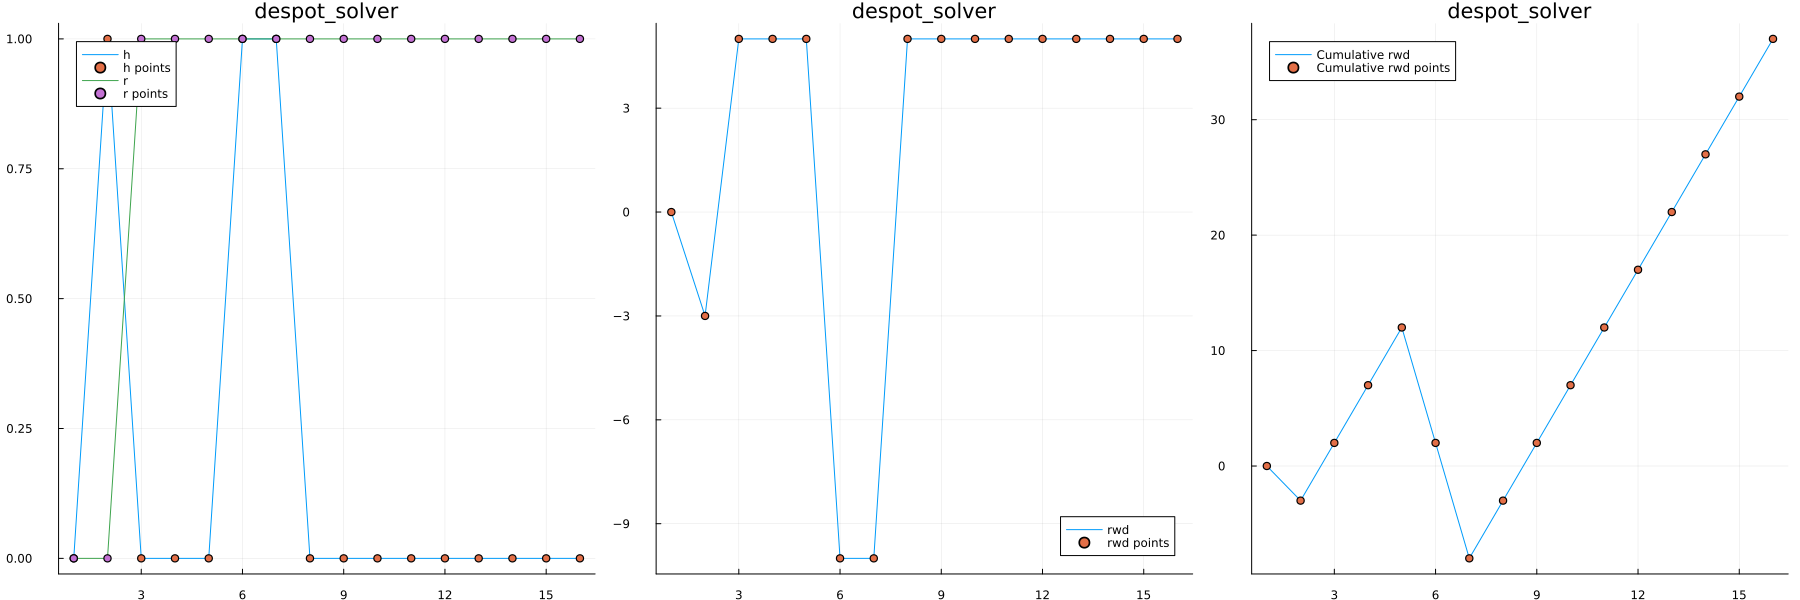

In [42]:
plot_title = "despot_solver"
plot_data(human_pos, robot_pos, reward_pos, plot_title)

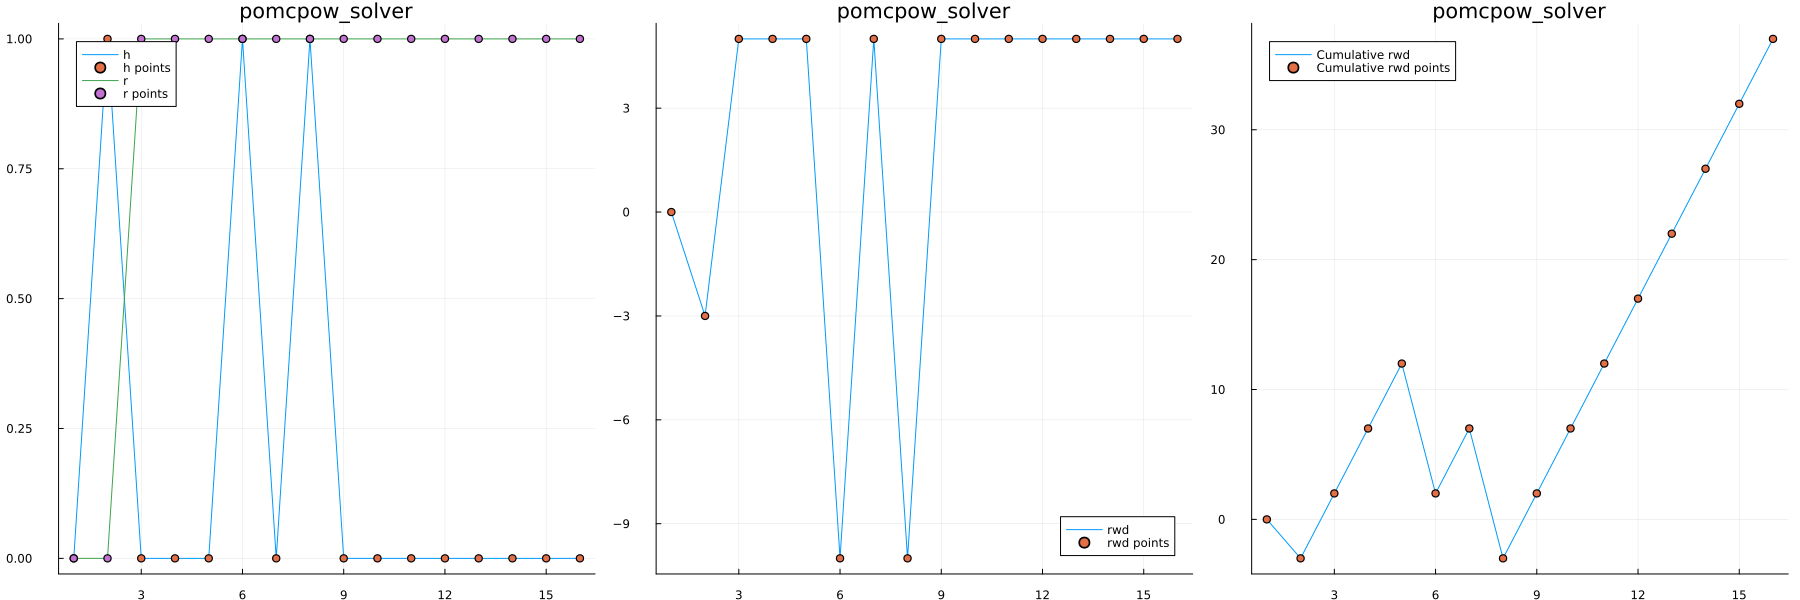

In [ ]:
pbvi_solver = PBVISolver()
pbvi_policy = solve(pbvi_solver, mdp_3)
human_pos = []
robot_pos = []
reward_pos = []

for (s, a, r) in stepthrough(mdp_3, pbvi_policy, "s, a, r", max_steps=30)
    @show s
    @show a
    @show r
    push!(human_pos, s.h)
    push!(robot_pos, s.r)
    push!(reward_pos, r)
end

In [45]:
# Create and run the rollout simulator
rollout_sim = RolloutSimulator(max_steps=10);
pbvi_reward = simulate(rollout_sim, mdp_3, pbvi_policy);
rand_reward = simulate(rollout_sim, mdp_3, rand_policy);
@show pbvi_reward;
@show rand_reward;

UndefVarError: UndefVarError: `rand_policy` not defined